# Use previously trained models for inference on testing dataset and make figures

In [1]:
# model version to be loaded and tested
v=2

In [2]:
import tensorflow as tf

In [3]:
import numpy as np
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# Load the testing and reflectivity data
prefix="/sep/nmbader/data/cs230/"
mig2=np.load(prefix+"mig2_batch960_augmented.npy") # double migration
mig1=np.load(prefix+"mig1_batch960_augmented.npy") # single migration
reflectivity=np.load(prefix+"reflectivity_batch960_augmented.npy") # single migration

nexamples=reflectivity.shape[0]
nw=reflectivity.shape[1]
nh=reflectivity.shape[2]
nc=1

# reshape
mig2 = np.reshape(mig2,(nexamples, nw, nh, nc))
mig1 = np.reshape(mig1,(nexamples, nw, nh, nc))
reflectivity = np.reshape(reflectivity,(nexamples, nw, nh, nc))

In [5]:
# Load a pre-trained model
LSMNet = tf.keras.models.load_model(prefix+'LSMNet_v'+str(v))

In [6]:
# run the inference on mig2 and mig1
predicted_mig1 = LSMNet.predict(
    x=mig2,
)
predicted_reflectivity = LSMNet.predict(
    x=mig1,
)

In [7]:
# cosine similarity metric
cs_m1_m2=np.zeros(nexamples) # mig1-mig2
cs_m1_pm1=np.zeros(nexamples) # mig1-predicted mig1
cs_r_m1=np.zeros(nexamples) # reflectivity-mig1
cs_r_pr=np.zeros(nexamples) # reflectivity-predicted reflectivity
for i in range(nexamples):
    cs_m1_m2[i] = np.sum(mig1[i]*mig2[i])/(np.linalg.norm(mig1[i])*np.linalg.norm(mig2[i]))
    cs_m1_pm1[i] = np.sum(mig1[i]*predicted_mig1[i])/(np.linalg.norm(mig1[i])*np.linalg.norm(predicted_mig1[i]))    
    cs_r_m1[i] = np.sum(mig1[i]*reflectivity[i])/(np.linalg.norm(mig1[i])*np.linalg.norm(reflectivity[i]))    
    cs_r_pr[i] = np.sum(mig1[i]*predicted_reflectivity[i])/(np.linalg.norm(mig1[i])*np.linalg.norm(predicted_reflectivity[i]))    

### global quality control

Mean = 0.914723
Median = 0.915055


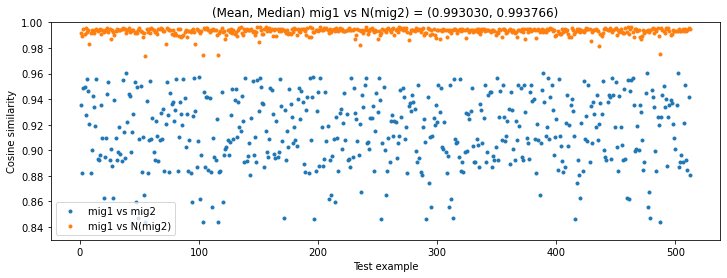

In [8]:
plt.figure(figsize=(12,4))
plt.scatter(np.linspace(1,nexamples,nexamples),cs_m1_m2,marker='.',label="mig1 vs mig2")
plt.scatter(np.linspace(1,nexamples,nexamples),cs_m1_pm1,marker='.',label="mig1 vs N(mig2)")
plt.xlabel("Test example")
plt.ylabel("Cosine similarity")
plt.ylim([0.83,1.0])
plt.legend()
plt.title("(Mean, Median) mig1 vs N(mig2) = (%f, %f)" %(np.mean(cs_m1_pm1),np.median(cs_m1_pm1)))

plt.savefig("fig/LSMNet_v"+str(v)+"_mig1_mig2.png")

print("Mean = %f" %np.mean(cs_m1_m2))
print("Median = %f" %np.median(cs_m1_m2))

Mean = 0.947176
Median = 0.950686


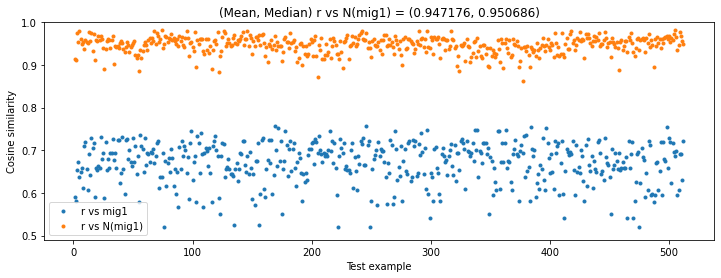

In [9]:
plt.figure(figsize=(12,4))
plt.scatter(np.linspace(1,nexamples,nexamples),cs_r_m1,marker='.',label="r vs mig1")
plt.scatter(np.linspace(1,nexamples,nexamples),cs_r_pr,marker='.',label="r vs N(mig1)")
plt.xlabel("Test example")
plt.ylabel("Cosine similarity")
plt.ylim([0.49,1.0])
plt.legend()
plt.title("(Mean, Median) r vs N(mig1) = (%f, %f)" %(np.mean(cs_r_pr),np.median(cs_r_pr)))

plt.savefig("fig/LSMNet_v"+str(v)+"_refl_mig1.png")

print("Mean = %f" %np.mean(cs_r_pr))
print("Median = %f" %np.median(cs_r_pr))

### Seismic figures

In [10]:
def shuffle_backward(l, seed):
    """Unshuffle the dataset that was previously shuffled with a given seed"""
    np.random.seed(seed)
    order = np.array(range(l.shape[0]))
    np.random.shuffle(order)
    
    l_out = np.zeros(l.shape)
    for i, j in enumerate(order):
        l_out[j] = l[i]
    return l_out

In [11]:
seed=1234
mig1_unshuff = shuffle_backward(mig1, seed)
predicted_reflectivity_unshuff = shuffle_backward(predicted_reflectivity, seed)
reflectivity_unshuff = shuffle_backward(reflectivity, seed)

In [12]:
# examples to use for images
i1=10
i2=45
i3=6
i4=12
elist=[i1, i2+64*2, i3+64, i4+64*3]
xmin=0
xmax=5.12 / 2
zmin=0
zmax=2.56 / 2

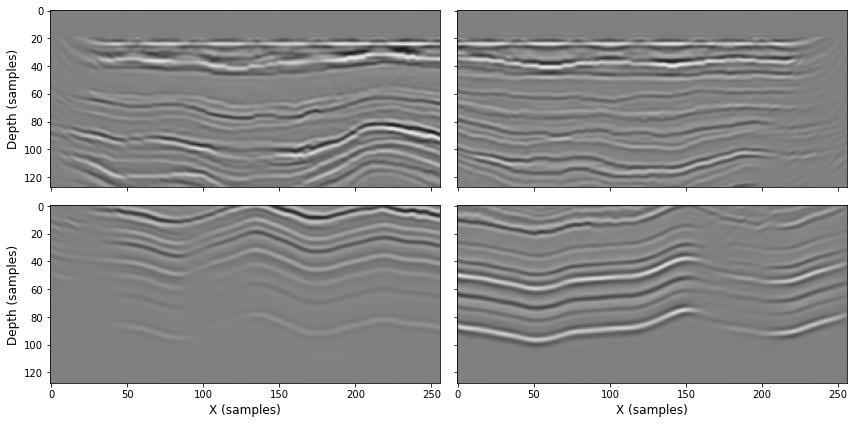

In [13]:
# dat=mig1_unshuff
dat=predicted_reflectivity_unshuff
# dat=reflectivity_unshuff

plt.figure(figsize=(12,6))

for e in range(len(elist)):
    plt.subplot(2,2,e+1)
    plt.imshow(np.transpose(np.squeeze(dat[elist[e]])), vmin=-1, vmax=1, cmap='gray',aspect='auto')
#     plt.colorbar()
    
    # plt.colorbar().set_label(label="Dimensionless",size=12)
    if e>1:
        plt.xlabel(r'X (samples)',fontsize=12)
    else:
        plt.gca().set_xticklabels([])
    if e==0 or e==2:
        plt.ylabel(r'Depth (samples)',fontsize=12)
    else:
        plt.gca().set_yticklabels([])
        
plt.tight_layout()


# plt.savefig('fig/mig1.png',bbox_inches='tight',format='png')
plt.savefig("fig/LSMNet_v"+str(v)+"_pred_refl.png",bbox_inches='tight',format='png')
# plt.savefig('fig/refl.png',bbox_inches='tight',format='png')

In [14]:
# save migration, reflectivity, and predicted reflectivity
# np.save("mig1",np.squeeze(mig1_unshuff[elist]))
# np.save("refl",np.squeeze(reflectivity_unshuff[elist]))
np.save("LSMNet_v"+str(v)+"_pred_refl",np.squeeze(predicted_reflectivity_unshuff[elist]))